In [1]:
import sys, ta
sys.path.append("..")
from utils import Db
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

In [2]:
db = Db("../cache")
df = db.get_symbols_as_dataframe(['AAPL'])
df['date_time'] = pd.to_datetime(df['date_time'])

plt.rcParams["figure.figsize"] = [9, 6]
%matplotlib notebook

In [3]:
df = df[df['date_time'] > datetime.now() - timedelta(days=365)]
df = df.reset_index()
df['bollinger_hband'] = ta.bollinger_hband(df['adjusted_close'])
df['bollinger_mavg'] = ta.bollinger_mavg(df['adjusted_close'])
df['bollinger_lband'] = ta.bollinger_lband(df['adjusted_close'])
df['bollinger_hband_indicator'] = ta.bollinger_hband_indicator(df['adjusted_close'])
df['bollinger_lband_indicator'] = ta.bollinger_lband_indicator(df['adjusted_close'])

scatter_data = df[['unix_time', 'adjusted_close', 'date_time']].as_matrix()
buy_signals, sell_signals = [], []
for i, ind in enumerate(df['bollinger_lband_indicator']):
    if ind == 1.0:
        date = scatter_data[i, 2]
        buy_signals.append(date)
for i, ind in enumerate(df['bollinger_hband_indicator']):
    if ind == 1.0:
        date = scatter_data[i, 2]
        sell_signals.append(date)

dates = scatter_data[:, 2]

<IPython.core.display.Javascript object>


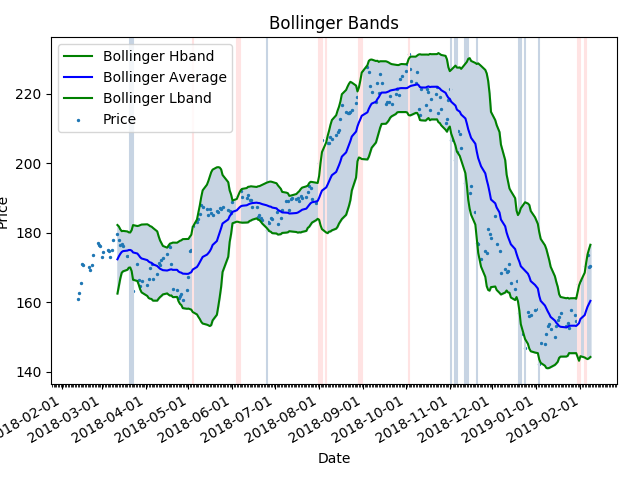

In [6]:
years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
yearsFmt = mdates.DateFormatter('%Y-%m-%d')
fig = plt.figure()
ax = fig.add_subplot(111)
for date in buy_signals:
    ax.axvline(date, color=[.78, .83, .89, 1.0])
for date in sell_signals:
    ax.axvline(date, color=[1.0, .89, .89, 1.0])
ax.plot(dates, df['bollinger_hband'], label='Bollinger Hband', color='green')
ax.plot(dates, df['bollinger_mavg'], label='Bollinger Average', color='blue')
ax.plot(dates, df['bollinger_lband'], label='Bollinger Lband', color='green')
ax.fill_between(dates, df['bollinger_hband'], df['bollinger_lband'], color=[.78, .83, .89, 1.0])
ax.scatter(dates, scatter_data[:, 1].tolist(), label='Price', s=2)



ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(yearsFmt)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.title('Bollinger Bands')

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [5]:
start_money = 100000.
current_money = start_money
shares = 0.
for i, current_adjusted_close in enumerate(df['adjusted_close']):
    if i > 0:
        #buy signal
        if df['bollinger_lband_indicator'].loc[i] == 1.0:
            buying = np.floor(current_money / current_adjusted_close)
            shares += buying
            current_money -= buying * current_adjusted_close
        elif df['bollinger_hband_indicator'].loc[i] == 1.0:
            current_money += current_adjusted_close * shares
            shares = 0

#sell all of our shares left over at the current price to get the value at the end
end_price = df['adjusted_close'][df.index[-1]]
extra_money = shares * end_price
current_money += extra_money

#calculate buy and hold
start_price = df['adjusted_close'].loc[0]
start_shares = np.floor(start_money / start_price)
bnh_current_money = start_money - (start_shares * start_price)
end_money = end_price * start_shares
end_money += bnh_current_money


print("Bollinger Band Indicator Trading: $" + str(current_money))
print("Buy and Hold: $" + str(end_money))
diff = current_money - end_money
print("MACD vs Buy and Hold: " + "+"+str(diff) if diff > 0 else diff )
print("Profit: " + (str(current_money - start_money)))
print("Number of Trades: " + str(len(buy_signals) + len(sell_signals)))

Bollinger Band Indicator Trading: $94888.4116
Buy and Hold: $105874.1011
-10985.6895
Profit: -5111.5884
Number of Trades: 32
